<a href="https://colab.research.google.com/github/cacomixtl/image-classification/blob/main/Stanford_Cars_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

# Check if GPU is available
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"GPU detected: {gpu_devices}")
    # Optional: Print details about the GPU
    # for device in gpu_devices:
    #     tf.config.experimental.get_device_details(device)
else:
    print("No GPU detected. Please ensure you've selected GPU in Runtime > Change runtime type.")

# Set memory growth to True to avoid allocating all GPU memory at once (good practice)
try:
    for gpu in gpu_devices:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("GPU memory growth enabled.")
except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(f"Error setting memory growth: {e}")

GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU memory growth enabled.


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, ResNet50V2, MobileNetV2 # Example pre-trained models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder # Useful if labels are strings initially

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 # OpenCV for potential image loading/manipulation if needed
import os # For interacting with the file system (paths)
import scipy.io # For loading .mat annotation files

# Set random seeds for reproducibility (optional but recommended)
np.random.seed(42)
tf.random.set_seed(42)

# Print library versions (good practice)
print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print(f"Scikit-learn Version: {sklearn.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"OpenCV Version: {cv2.__version__}")

TensorFlow Version: 2.18.0
Keras Version: 3.8.0
Scikit-learn Version: 1.6.1
Pandas Version: 2.2.2
NumPy Version: 2.0.2
OpenCV Version: 4.11.0


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import os
from pathlib import Path # Use pathlib for cleaner path manipulation
from typing import List, Tuple # For type hinting

# --- Configuration ---

# !!! IMPORTANT: EDIT THIS RELATIVE PATH !!!
# This should be the path *relative* to your Google Drive's root folder
# where the main 'Stanford_Cars_Dataset' top folder resides.
# Example: If your dataset is in 'MyDrive/Colab Notebooks/MyStanfordCars',
# this should be: 'Colab Notebooks/MyStanfordCars'
RELATIVE_DATASET_PATH_IN_DRIVE: str = 'Stanford_Cars_Dataset' # <--- EDIT THIS (Use your actual top folder name/path)

# --- Environment Assumptions ---
# Assumes running in an environment like Google Colab where Drive is mounted.
DRIVE_MOUNT_POINT: Path = Path('/content/drive/MyDrive/')

# --- Assumed Subdirectory Structure based on latest examples ---
# CSVs expected directly within: .../{RELATIVE_DATASET_PATH_IN_DRIVE}/
# Images expected within:       .../{RELATIVE_DATASET_PATH_IN_DRIVE}/car_data/car_dataset/[train|test]/...
IMAGE_SUBDIR_NESTING = Path('car_data') / 'car_dataset' # Nested structure for images

# --- Path Definitions ---
paths_defined = False
TOP_PROJECT_FOLDER = DRIVE_MOUNT_POINT / RELATIVE_DATASET_PATH_IN_DRIVE

# Check if the top project folder exists
if not DRIVE_MOUNT_POINT.exists():
    print(f"❌ ERROR: Google Drive mount point not found at '{DRIVE_MOUNT_POINT}'")
elif not TOP_PROJECT_FOLDER.exists():
     print(f"❌ ERROR: The top project folder specified does not exist!")
     print(f"   Specified relative path: '{RELATIVE_DATASET_PATH_IN_DRIVE}'")
     print(f"   Looked for absolute path: '{TOP_PROJECT_FOLDER}'")
     print(f"   Troubleshooting:")
     print(f"     1. Did you edit 'RELATIVE_DATASET_PATH_IN_DRIVE' correctly?")
     print(f"     2. Is the casing (uppercase/lowercase) correct?")
     print(f"     3. Is your Drive mounted?")
else:
    print(f"✅ Found Top Project Folder: '{TOP_PROJECT_FOLDER}'")

    # --- Define CSV Paths (directly under TOP_PROJECT_FOLDER) ---
    TRAIN_ANNOTATIONS_CSV: Path = TOP_PROJECT_FOLDER / 'anno_train.csv'
    TEST_ANNOTATIONS_CSV: Path = TOP_PROJECT_FOLDER / 'anno_test.csv'
    CLASS_NAMES_CSV: Path = TOP_PROJECT_FOLDER / 'names.csv'

    # --- Define Image Paths (under nested subdirectories) ---
    IMAGE_BASE_PATH: Path = TOP_PROJECT_FOLDER / IMAGE_SUBDIR_NESTING

    TRAIN_IMAGE_FOLDER: Path = IMAGE_BASE_PATH / 'train'
    # Example image path: TRAIN_IMAGE_FOLDER / 'Acura Integra Type R 2001' / '00128.jpg'

    TEST_IMAGE_FOLDER: Path = IMAGE_BASE_PATH / 'test'
    # Example image path: TEST_IMAGE_FOLDER / 'Aston Martin V8 Vantage Coupe 2012' / '00001.jpg'

    paths_defined = True # Mark paths as successfully defined

# --- Verification Function ---

def verify_dataset_paths(files_to_check: List[Path], folders_to_check: List[Path], top_folder: Path, image_nested_subdir: Path) -> bool:
    """
    Checks if all required files and folders exist at their specified paths.
    Requires the top_folder and image_nested_subdir paths for better error messages.
    """
    print(f"\n--- Verifying Specific File and Folder Paths ---")

    all_found = True
    required_items = files_to_check + folders_to_check

    if not required_items:
        print("⚠️ No files or folders provided for verification.")
        return False # Or True, depending on desired behavior for empty lists

    for item_path in required_items:
        is_expected_folder = item_path in folders_to_check
        is_expected_file = item_path in files_to_check
        item_type = "Folder" if is_expected_folder else "File"

        if item_path.exists():
            # Check if it's the correct type (file vs directory)
            if (is_expected_folder and not item_path.is_dir()) or \
               (is_expected_file and not item_path.is_file()):
                 print(f"  ❌ ERROR: Path exists but is not the correct type ({item_type}): {item_path}")
                 all_found = False
            else:
                print(f"  ✅ Found {item_type}: {item_path}")
        else:
            print(f"  ❌ ERROR: Missing {item_type}: {item_path}")
            all_found = False

    if all_found:
        print("\n✅ All required files and folders found at their specified locations.")
    else:
        print(f"\n❌ ERROR: Some required files/folders are missing or have the wrong type.")
        print(f"   Please check the paths printed above and your dataset structure.")
        print(f"   Ensure 'RELATIVE_DATASET_PATH_IN_DRIVE' points to the correct top-level folder ('{top_folder.name}').")
        print(f"   - CSV files (.csv) should be directly inside '{top_folder.name}'.")
        print(f"   - Image folders ('train', 'test') should be inside the nested structure: '{top_folder.name}/{image_nested_subdir}'.")

    return all_found

# --- Execute Verification ---
if paths_defined:
    # Create lists of the final paths to check
    required_files_list = [TRAIN_ANNOTATIONS_CSV, TEST_ANNOTATIONS_CSV, CLASS_NAMES_CSV]
    required_folders_list = [TRAIN_IMAGE_FOLDER, TEST_IMAGE_FOLDER]

    # Pass necessary info to verification function for clearer error messages
    paths_verified = verify_dataset_paths(
        required_files_list,
        required_folders_list,
        TOP_PROJECT_FOLDER,
        IMAGE_SUBDIR_NESTING
    )

    # Optional: Add further action based on verification
    # if not paths_verified:
    #     print("\nHalting execution due to path verification errors.")
    #     # raise FileNotFoundError("Dataset paths could not be verified.")

else:
    print("\nSkipping path verification because essential base paths could not be determined.")

✅ Found Top Project Folder: '/content/drive/MyDrive/Stanford_Cars_Dataset'

--- Verifying Specific File and Folder Paths ---
  ✅ Found File: /content/drive/MyDrive/Stanford_Cars_Dataset/anno_train.csv
  ✅ Found File: /content/drive/MyDrive/Stanford_Cars_Dataset/anno_test.csv
  ✅ Found File: /content/drive/MyDrive/Stanford_Cars_Dataset/names.csv
  ✅ Found Folder: /content/drive/MyDrive/Stanford_Cars_Dataset/car_data/car_dataset/train
  ✅ Found Folder: /content/drive/MyDrive/Stanford_Cars_Dataset/car_data/car_dataset/test

✅ All required files and folders found at their specified locations.


# **Phase Two**

Phase 2.1

In [28]:
# --- Ensure these Variables are Correctly Set from Phase 1 ---
# Example definitions (MAKE SURE THESE MATCH YOUR ACTUAL PHASE 1 SETUP)
# DRIVE_MOUNT_POINT = '/content/drive/MyDrive/'
# YOUR_TOP_DATASET_FOLDER_PATH_IN_DRIVE = 'Your/Path/To/StanfordCars' # e.g., 'Colab Notebooks/Datasets/Stanford_Cars_Dataset'
# BASE_PROJECT_PATH = os.path.join(DRIVE_MOUNT_POINT, YOUR_TOP_DATASET_FOLDER_PATH_IN_DRIVE)
# BASE_IMAGE_PATH = os.path.join(BASE_PROJECT_PATH, 'car_data', 'car_dataset') # Path containing train/test folders
BASE_IMAGE_PATH = os.path.join(DRIVE_MOUNT_POINT, RELATIVE_DATASET_PATH_IN_DRIVE, 'car_data', 'car_dataset') # Path containing train/test folders
# TRAIN_ANNOTATIONS_CSV = os.path.join(BASE_PROJECT_PATH, 'anno_train.csv')
# TEST_ANNOTATIONS_CSV = os.path.join(BASE_PROJECT_PATH, 'anno_test.csv')
# CLASS_NAMES_CSV = os.path.join(BASE_PROJECT_PATH, 'names.csv')
#--------------------------------------------------------------

import os
import pandas as pd # Ensure pandas is imported

print("--- Verifying Essential Paths ---")

required_files = {
    "Train Annotations": TRAIN_ANNOTATIONS_CSV,
    "Test Annotations": TEST_ANNOTATIONS_CSV,
    "Class Names": CLASS_NAMES_CSV
}
required_dirs = {
    "Base Image Path": BASE_IMAGE_PATH,
    "Train Images Base": os.path.join(BASE_IMAGE_PATH, 'train'), # Dir containing class folders
    "Test Images Base": os.path.join(BASE_IMAGE_PATH, 'test')   # Dir containing class folders
}

all_paths_ok = True
for name, path in required_files.items():
    print(f"Checking File: {name} at {path}")
    if os.path.exists(path):
        print(" -> Found.")
    else:
        print(f" -> ERROR: File not found! Check path definition.")
        all_paths_ok = False

for name, path in required_dirs.items():
    print(f"Checking Directory: {name} at {path}")
    if os.path.exists(path):
        print(f" -> Found. Sample content: {os.listdir(path)[:3]}") # Show first 3 items
    else:
        print(f" -> ERROR: Directory not found! Check path definition.")
        all_paths_ok = False

if not all_paths_ok:
    print("\nERROR: One or more essential paths are incorrect. Please fix Phase 1 definitions before proceeding.")
else:
    print("\nEssential paths seem correct. Proceeding...")

# Define these base directories for image paths later
TRAIN_CLASSES_BASE_DIR = os.path.join(BASE_IMAGE_PATH, 'train')
TEST_CLASSES_BASE_DIR = os.path.join(BASE_IMAGE_PATH, 'test')

--- Verifying Essential Paths ---
Checking File: Train Annotations at /content/drive/MyDrive/Stanford_Cars_Dataset/anno_train.csv
 -> Found.
Checking File: Test Annotations at /content/drive/MyDrive/Stanford_Cars_Dataset/anno_test.csv
 -> Found.
Checking File: Class Names at /content/drive/MyDrive/Stanford_Cars_Dataset/names.csv
 -> Found.
Checking Directory: Base Image Path at /content/drive/MyDrive/Stanford_Cars_Dataset/car_data/car_dataset
 -> Found. Sample content: ['test', 'train']
Checking Directory: Train Images Base at /content/drive/MyDrive/Stanford_Cars_Dataset/car_data/car_dataset/train
 -> Found. Sample content: ['Acura Integra Type R 2001', 'AM General Hummer SUV 2000', 'Acura TL Type-S 2008']
Checking Directory: Test Images Base at /content/drive/MyDrive/Stanford_Cars_Dataset/car_data/car_dataset/test
 -> Found. Sample content: ['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012']

Essential paths seem correct. Proceeding...


#2.2

In [29]:
# Define column names for annotation files (train/test)
anno_cols = ['filename', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class_id']

# Define column name for the class names file
names_col = ['class_name']

print("Column names defined:")
print(f"Annotation Columns: {anno_cols}")
print(f"Names Column: {names_col}")

Column names defined:
Annotation Columns: ['filename', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class_id']
Names Column: ['class_name']


#2.3

In [30]:
try:
    # Reload the CSV files specifying no header and assigning names
    train_annos_df = pd.read_csv(TRAIN_ANNOTATIONS_CSV, header=None, names=anno_cols)
    test_annos_df = pd.read_csv(TEST_ANNOTATIONS_CSV, header=None, names=anno_cols)
    class_names_df = pd.read_csv(CLASS_NAMES_CSV, header=None, names=names_col)

    print("--- Training Annotations (Loaded) ---")
    print(f"Shape: {train_annos_df.shape}")
    if train_annos_df.shape[0] == 8144: print(" -> Correct sample count.")
    else: print(f" -> Warning: Expected 8144 samples, got {train_annos_df.shape[0]}.")
    print(train_annos_df.head(3))

    print("\n--- Test Annotations (Loaded) ---")
    print(f"Shape: {test_annos_df.shape}")
    if test_annos_df.shape[0] == 8041: print(" -> Correct sample count.")
    else: print(f" -> Warning: Expected 8041 samples, got {test_annos_df.shape[0]}.")
    print(test_annos_df.head(3))

    print("\n--- Class Names (Loaded) ---")
    print(f"Shape: {class_names_df.shape}")
    if class_names_df.shape[0] == 196: print(" -> Correct class count.")
    else: print(f" -> Warning: Expected 196 classes, got {class_names_df.shape[0]}.")
    print(class_names_df.head(3))

except FileNotFoundError as e:
    print(f"Error loading CSV file: {e}")
    print("Please ensure the paths verified in Cell 2.1 are correct.")
except Exception as e:
    print(f"An error occurred during loading: {e}")

--- Training Annotations (Loaded) ---
Shape: (8144, 6)
 -> Correct sample count.
    filename  bbox_x1  bbox_y1  bbox_x2  bbox_y2  class_id
0  00001.jpg       39      116      569      375        14
1  00002.jpg       36      116      868      587         3
2  00003.jpg       85      109      601      381        91

--- Test Annotations (Loaded) ---
Shape: (8041, 6)
 -> Correct sample count.
    filename  bbox_x1  bbox_y1  bbox_x2  bbox_y2  class_id
0  00001.jpg       30       52      246      147       181
1  00002.jpg      100       19      576      203       103
2  00003.jpg       51      105      968      659       145

--- Class Names (Loaded) ---
Shape: (196, 1)
 -> Correct class count.
                   class_name
0  AM General Hummer SUV 2000
1         Acura RL Sedan 2012
2         Acura TL Sedan 2012


#2.4

In [31]:
try:
    # Add a 'class_id' column (1-based index)
    class_names_df['class_id'] = class_names_df.index + 1

    print("--- Class Names with Added 'class_id' ---")
    print(class_names_df.head())
    print(f"\nMin class_id in names table: {class_names_df['class_id'].min()}")
    print(f"Max class_id in names table: {class_names_df['class_id'].max()}")

    # Check Class ID Range in Annotations
    min_train_id = train_annos_df['class_id'].min()
    max_train_id = train_annos_df['class_id'].max()
    min_test_id = test_annos_df['class_id'].min()
    max_test_id = test_annos_df['class_id'].max()
    print(f"\nTrain Annotation Class IDs range: {min_train_id} - {max_train_id}")
    print(f"Test Annotation Class IDs range: {min_test_id} - {max_test_id}")

    # Verify consistency
    if class_names_df['class_id'].max() != max(max_train_id, max_test_id):
         print("\nWarning: Max class ID in annotations doesn't match max ID in names file!")
    elif class_names_df['class_id'].min() != min(min_train_id, min_test_id):
         print("\nWarning: Min class ID in annotations doesn't match min ID in names file!")
    else:
        print("\nClass ID ranges appear consistent between names and annotations.")

except NameError:
     print("Error: Ensure train_annos_df, test_annos_df, class_names_df were loaded correctly in the previous cell.")
except KeyError as e:
     print(f"Error accessing expected column: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

--- Class Names with Added 'class_id' ---
                   class_name  class_id
0  AM General Hummer SUV 2000         1
1         Acura RL Sedan 2012         2
2         Acura TL Sedan 2012         3
3        Acura TL Type-S 2008         4
4        Acura TSX Sedan 2012         5

Min class_id in names table: 1
Max class_id in names table: 196

Train Annotation Class IDs range: 1 - 196
Test Annotation Class IDs range: 1 - 196

Class ID ranges appear consistent between names and annotations.


#2.5

In [32]:
try:
    # Merge train annotations with class names
    train_df = pd.merge(
        train_annos_df,
        class_names_df,
        on='class_id', # Merge on the common 'class_id' column
        how='left'     # Keep all annotations
    )

    # Merge test annotations with class names
    test_df = pd.merge(
        test_annos_df,
        class_names_df,
        on='class_id', # Merge on the common 'class_id' column
        how='left'
    )

    # Keep only necessary columns (drop bounding boxes etc.)
    keep_cols = ['filename', 'class_id', 'class_name']
    train_df = train_df[keep_cols]
    test_df = test_df[keep_cols]

    print("--- Merged Training DataFrame (Selected Columns) ---")
    print(f"Shape: {train_df.shape}")
    print(train_df.head())
    if train_df['class_name'].isnull().any():
        print(f"Warning: {train_df['class_name'].isnull().sum()} missing class names in train_df.")

    print("\n--- Merged Test DataFrame (Selected Columns) ---")
    print(f"Shape: {test_df.shape}")
    print(test_df.head())
    if test_df['class_name'].isnull().any():
        print(f"Warning: {test_df['class_name'].isnull().sum()} missing class names in test_df.")

except NameError:
     print("Error: Ensure train_annos_df, test_annos_df, class_names_df were loaded correctly.")
except KeyError as e:
     print(f"Error accessing expected column during merge: {e}")
except Exception as e:
    print(f"An error occurred during merge: {e}")

--- Merged Training DataFrame (Selected Columns) ---
Shape: (8144, 3)
    filename  class_id                           class_name
0  00001.jpg        14                  Audi TTS Coupe 2012
1  00002.jpg         3                  Acura TL Sedan 2012
2  00003.jpg        91           Dodge Dakota Club Cab 2007
3  00004.jpg       134     Hyundai Sonata Hybrid Sedan 2012
4  00005.jpg       106  Ford F-450 Super Duty Crew Cab 2012

--- Merged Test DataFrame (Selected Columns) ---
Shape: (8041, 3)
    filename  class_id                           class_name
0  00001.jpg       181              Suzuki Aerio Sedan 2007
1  00002.jpg       103  Ferrari 458 Italia Convertible 2012
2  00003.jpg       145                Jeep Patriot SUV 2012
3  00004.jpg       187              Toyota Camry Sedan 2012
4  00005.jpg       185             Tesla Model S Sedan 2012


#2.6

In [33]:
# CELL 2.6 (REVISED FOR PATHLIB)

import pandas as pd
from pathlib import Path # Ensure pathlib is imported if not already in scope

try:
    # TRAIN_CLASSES_BASE_DIR and TEST_CLASSES_BASE_DIR should be Path objects from Cell 2.1
    if not isinstance(TRAIN_CLASSES_BASE_DIR, Path) or not isinstance(TEST_CLASSES_BASE_DIR, Path):
         print("Warning: TRAIN_CLASSES_BASE_DIR or TEST_CLASSES_BASE_DIR are not Path objects. Converting.")
         TRAIN_CLASSES_BASE_DIR = Path(TRAIN_CLASSES_BASE_DIR)
         TEST_CLASSES_BASE_DIR = Path(TEST_CLASSES_BASE_DIR)

    if not TRAIN_CLASSES_BASE_DIR.exists() or not TEST_CLASSES_BASE_DIR.exists():
        raise FileNotFoundError("Base directories for train/test class folders not found. Check Cell 2.1.")

    print("Generating filepaths using pathlib...")
    # Create the correct filepath using pathlib's / operator
    # The resulting 'filepath' column will contain Path objects temporarily
    train_df['filepath'] = train_df.apply(
        lambda row: TRAIN_CLASSES_BASE_DIR / str(row['class_name']).replace('/','-') / str(row['filename']) if pd.notna(row['class_name']) else None,
        axis=1
    )
    test_df['filepath'] = test_df.apply(
        lambda row: TEST_CLASSES_BASE_DIR / str(row['class_name']).replace('/','-') / str(row['filename']) if pd.notna(row['class_name']) else None,
        axis=1
    )

    # Handle and report rows where filepath couldn't be generated
    num_missing_train_paths = train_df['filepath'].isnull().sum()
    num_missing_test_paths = test_df['filepath'].isnull().sum()
    if num_missing_train_paths > 0:
        print(f"Warning: Could not generate filepath for {num_missing_train_paths} training samples (likely missing class_name).")
    if num_missing_test_paths > 0:
        print(f"Warning: Could not generate filepath for {num_missing_test_paths} test samples (likely missing class_name).")

    # Drop rows with missing filepaths if they exist, as they cannot be used
    initial_train_count = len(train_df)
    initial_test_count = len(test_df)
    train_df = train_df.dropna(subset=['filepath'])
    test_df = test_df.dropna(subset=['filepath'])
    if len(train_df) < initial_train_count:
        print(f"Removed {initial_train_count - len(train_df)} training rows with missing filepaths.")
    if len(test_df) < initial_test_count:
        print(f"Removed {initial_test_count - len(test_df)} test rows with missing filepaths.")


    print("\n--- Training DataFrame with Final Filepath (Path Objects) ---")
    print(train_df.head()) # Note: filepath column contains Path objects now

    # --- Verification: Check one generated path using Path methods ---
    if not train_df.empty:
        # Ensure the column contains Path objects before accessing Path methods
        if pd.api.types.is_object_dtype(train_df['filepath']) and isinstance(train_df.iloc[0]['filepath'], Path):
             first_train_path_final_obj: Path = train_df.iloc[0]['filepath']
             print(f"\nChecking existence of first generated training image path: {first_train_path_final_obj}")
             print(f"Exists: {first_train_path_final_obj.exists()}") # Use Path.exists()
             if not first_train_path_final_obj.exists():
                  print("-> If path looks correct but still doesn't exist:")
                  print("   1. Double-check case sensitivity & exact names of class folders and image files.")
                  class_dir_path: Path = first_train_path_final_obj.parent # Use Path.parent
                  if class_dir_path.exists() and class_dir_path.is_dir():
                       # Use list comprehension with Path.name for cleaner output
                       contents = [p.name for p in class_dir_path.iterdir()]
                       print(f"   Actual contents of class directory '{class_dir_path.name}' (first 5): {contents[:5]}")
                  else:
                       print(f"   Class directory does not exist or is not a directory: {class_dir_path}")
        else:
             print("Warning: First filepath in DataFrame is not a Path object, cannot use Path methods for verification.")


    # --- Convert filepath column to string for broader compatibility ---
    # This ensures subsequent cells using libraries like matplotlib/cv2 work reliably
    print("\nConverting filepath column to string type...")
    train_df['filepath'] = train_df['filepath'].astype(str)
    test_df['filepath'] = test_df['filepath'].astype(str)
    print("Filepath column converted to string.")
    print("\n--- Training DataFrame with Final Filepath (String Type) ---")
    print(train_df.head())


except NameError as e:
     print(f"Error: Make sure train_df, test_df, TRAIN_CLASSES_BASE_DIR, TEST_CLASSES_BASE_DIR are defined: {e}")
except KeyError as e:
    print(f"Error: Missing column required for path generation: {e}. Need 'filename' and 'class_name'.")
except FileNotFoundError as e:
     print(f"Error: {e}") # Catch specific error from check
except ImportError:
     print("Error: Could not import pathlib. Make sure it's available.")
except Exception as e:
    print(f"An error occurred during filepath generation: {e}")

Generating filepaths using pathlib...

--- Training DataFrame with Final Filepath (Path Objects) ---
    filename  class_id                           class_name  \
0  00001.jpg        14                  Audi TTS Coupe 2012   
1  00002.jpg         3                  Acura TL Sedan 2012   
2  00003.jpg        91           Dodge Dakota Club Cab 2007   
3  00004.jpg       134     Hyundai Sonata Hybrid Sedan 2012   
4  00005.jpg       106  Ford F-450 Super Duty Crew Cab 2012   

                                            filepath  
0  /content/drive/MyDrive/Stanford_Cars_Dataset/c...  
1  /content/drive/MyDrive/Stanford_Cars_Dataset/c...  
2  /content/drive/MyDrive/Stanford_Cars_Dataset/c...  
3  /content/drive/MyDrive/Stanford_Cars_Dataset/c...  
4  /content/drive/MyDrive/Stanford_Cars_Dataset/c...  

Checking existence of first generated training image path: /content/drive/MyDrive/Stanford_Cars_Dataset/car_data/car_dataset/train/Audi TTS Coupe 2012/00001.jpg
Exists: True

Converting fil

#2.7

In [34]:
try:
    num_train_images = len(train_df)
    num_test_images = len(test_df)
    num_classes_by_id = train_df['class_id'].nunique()
    num_classes_by_name = train_df['class_name'].nunique()

    print(f"\n--- Final Data Exploration ---")
    print(f"Number of usable training samples: {num_train_images}")
    print(f"Number of usable test samples: {num_test_images}")
    print(f"Number of unique classes by ID in training data: {num_classes_by_id}")
    print(f"Number of unique classes by Name in training data: {num_classes_by_name}")

    # Standard counts
    expected_train = 8144
    expected_test = 8041
    expected_classes = 196

    if num_train_images != expected_train: print(f"Warning: Train count ({num_train_images}) differs from expected ({expected_train}).")
    if num_test_images != expected_test: print(f"Warning: Test count ({num_test_images}) differs from expected ({expected_test}).")
    if num_classes_by_id != expected_classes: print(f"Warning: Class ID count ({num_classes_by_id}) differs from expected ({expected_classes}).")
    if num_classes_by_name != expected_classes: print(f"Warning: Class Name count ({num_classes_by_name}) differs from expected ({expected_classes}).")


except NameError:
    print("Error: Ensure train_df and test_df were created successfully.")
except KeyError as e:
    print(f"Error: Ensure the columns 'class_id' and 'class_name' exist.")
except Exception as e:
    print(f"An error occurred: {e}")


--- Final Data Exploration ---
Number of usable training samples: 8144
Number of usable test samples: 8041
Number of unique classes by ID in training data: 196
Number of unique classes by Name in training data: 196


#2.8


--- Class Distribution Analysis (Final Training Set) ---
Total unique classes found: 196
Mean images per class: 41.55
Median images per class: 42.0
Min images per class: 24 (Class: Hyundai Accent Sedan 2012)
Max images per class: 68 (Class: GMC Savana Van 2012)


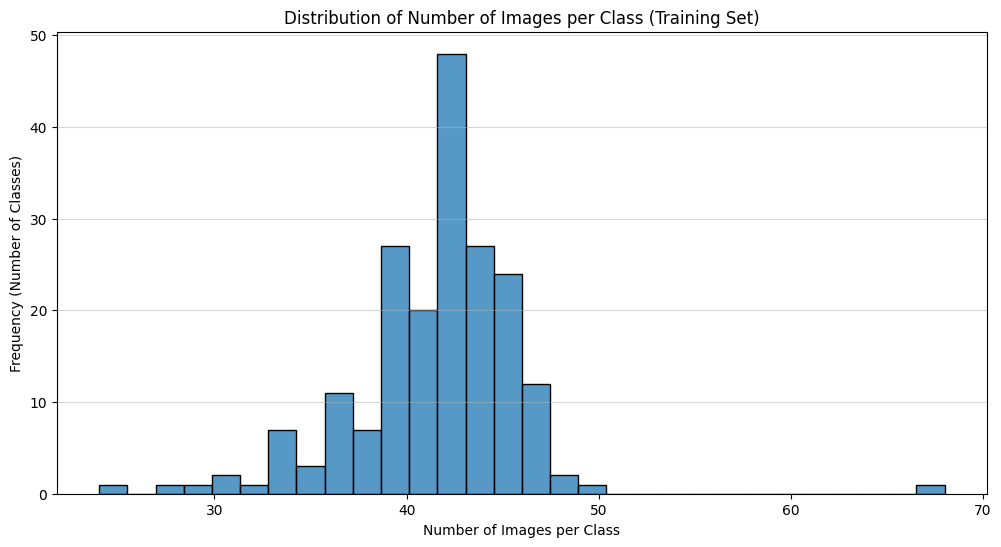


Top 10 Most Frequent Classes:
class_name
GMC Savana Van 2012                         68
Chrysler 300 SRT-8 2010                     49
Mitsubishi Lancer Sedan 2012                48
Mercedes-Benz 300-Class Convertible 1993    48
Jaguar XK XKR 2012                          47
Chevrolet Corvette ZR1 2012                 47
Volkswagen Golf Hatchback 1991              46
Nissan 240SX Coupe 1998                     46
Audi S6 Sedan 2011                          46
Bentley Continental GT Coupe 2007           46
Name: count, dtype: int64

Bottom 10 Least Frequent Classes:
class_name
BMW ActiveHybrid 5 Sedan 2012                          34
Infiniti QX56 SUV 2011                                 33
Bugatti Veyron 16.4 Convertible 2009                   33
Aston Martin Virage Convertible 2012                   33
Acura RL Sedan 2012                                    32
Rolls-Royce Phantom Drophead Coupe Convertible 2012    31
Chevrolet Express Cargo Van 2007                       30
Maybach La

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Ensure numpy is imported

try:
    print("\n--- Class Distribution Analysis (Final Training Set) ---")
    if not train_df.empty:
        class_counts = train_df['class_name'].value_counts()

        print(f"Total unique classes found: {len(class_counts)}")
        if not class_counts.empty:
            print(f"Mean images per class: {class_counts.mean():.2f}")
            print(f"Median images per class: {class_counts.median()}")
            print(f"Min images per class: {class_counts.min()} (Class: {class_counts.idxmin()})")
            print(f"Max images per class: {class_counts.max()} (Class: {class_counts.idxmax()})")

            # Plot distribution of counts
            plt.figure(figsize=(12, 6))
            sns.histplot(class_counts, bins=min(30, len(class_counts))) # Adjust bins if fewer classes
            plt.title('Distribution of Number of Images per Class (Training Set)')
            plt.xlabel('Number of Images per Class')
            plt.ylabel('Frequency (Number of Classes)')
            plt.grid(axis='y', alpha=0.5)
            plt.show()

            # Show Top N and Bottom N classes
            N = 10
            print(f"\nTop {N} Most Frequent Classes:")
            print(class_counts.head(N))

            print(f"\nBottom {N} Least Frequent Classes:")
            print(class_counts.tail(N))
        else:
            print("No data available for class distribution analysis.")
    else:
        print("Train DataFrame is empty. Skipping distribution analysis.")

except NameError:
    print("Error: Ensure train_df was created successfully.")
except KeyError:
     print(f"Error: Ensure the column 'class_name' exists in train_df.")
except Exception as e:
    print(f"An error occurred during distribution analysis: {e}")

#2.9


--- Visualizing Sample Images ---


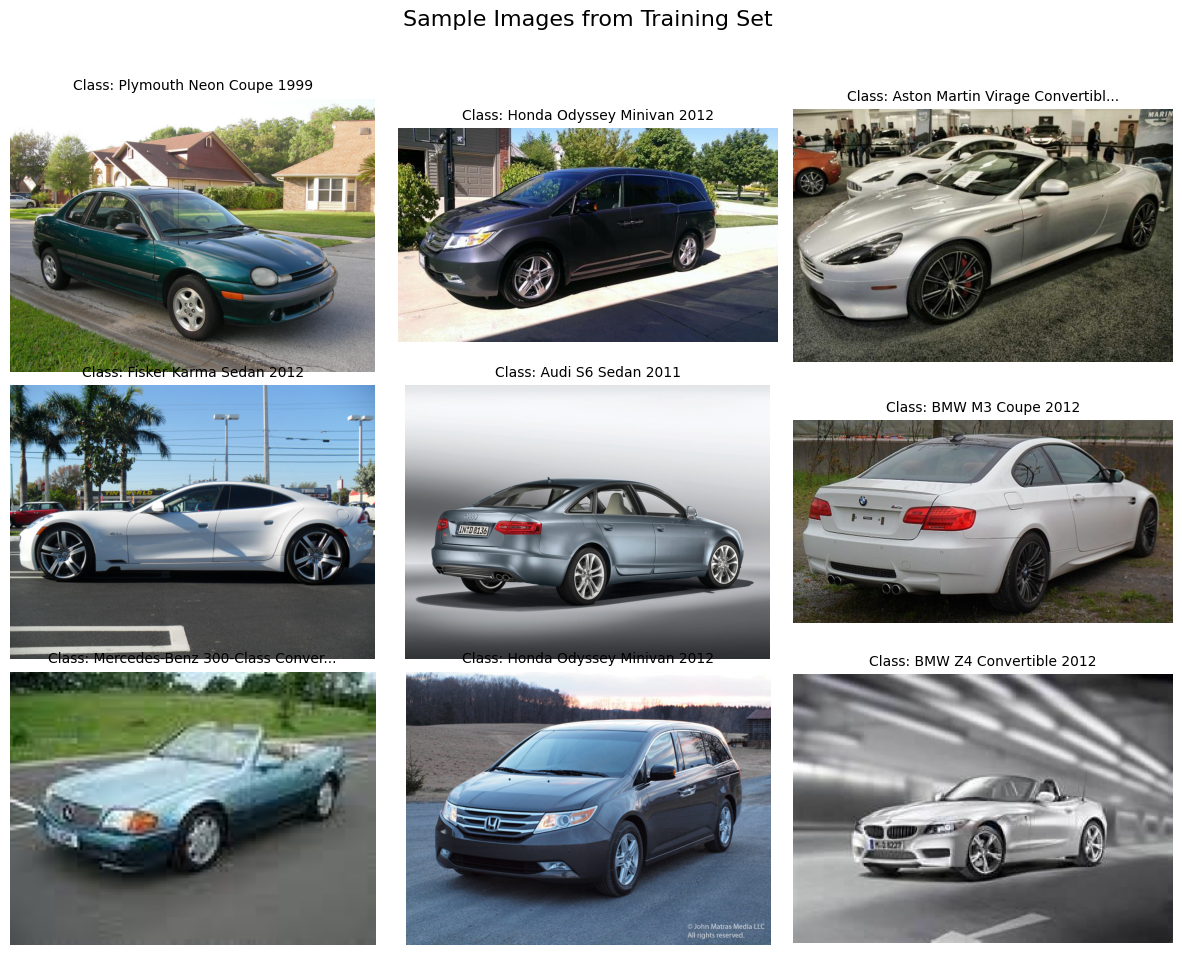

In [36]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# import cv2 # Or use OpenCV if preferred

try:
    print("\n--- Visualizing Sample Images ---")
    if not train_df.empty:
        num_samples_to_show = 9
        # Sample from the potentially cleaned train_df
        sample_df = train_df.sample(min(num_samples_to_show, len(train_df)))

        plt.figure(figsize=(12, 10))
        plt.suptitle("Sample Images from Training Set", fontsize=16)

        for i, (index, row) in enumerate(sample_df.iterrows()):
            img_path = row['filepath']
            img_label = row['class_name']

            plt.subplot(3, 3, i + 1) # Create a 3x3 grid
            try:
                img = mpimg.imread(img_path)
                # Or using OpenCV:
                # img = cv2.imread(img_path)
                # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                plt.imshow(img)
                # Shorten label if too long for title
                display_label = (img_label[:30] + '...') if len(img_label) > 30 else img_label
                plt.title(f"Class: {display_label}", fontsize=10)
                plt.axis('off')
            except FileNotFoundError:
                print(f"Warning: Image not found at {img_path}")
                plt.title(f"Image not found\n{display_label}", fontsize=10)
                plt.axis('off')
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                plt.title(f"Error loading\n{display_label}", fontsize=10)
                plt.axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        print("Train DataFrame is empty. Skipping visualization.")

except NameError:
    print("Error: Ensure train_df was created successfully.")
except KeyError:
     print("Error: Ensure columns 'filepath' and 'class_name' exist in train_df.")
except Exception as e:
    print(f"An error occurred during visualization: {e}")

#2.10

In [37]:
import cv2 # Using OpenCV here
import tqdm # For progress bar

try:
    print("\n--- Checking Image Dimensions (Sample) ---")
    unique_shapes = set()
    num_to_check = 50 # Check a small sample

    # Check some training images
    if not train_df.empty:
        print("Checking training images...")
        image_paths_to_check = train_df['filepath'].sample(min(num_to_check, len(train_df)))
        for filepath in tqdm.tqdm(image_paths_to_check):
            try:
                img = cv2.imread(filepath)
                if img is not None:
                    unique_shapes.add(img.shape)
                else:
                     print(f"\nWarning: Failed to read (cv2 returned None): {filepath}")
            except FileNotFoundError:
                 print(f"\nWarning: File not found during shape check: {filepath}") # Should be caught by earlier steps ideally
            except Exception as e:
                print(f"\nError reading {filepath} during shape check: {e}")
    else:
        print("Train DataFrame is empty. Skipping dimension check for train set.")

    # Check some test images (optional, usually train set is enough)
    # if not test_df.empty:
    #    print("Checking test images...")
    #    # Add similar loop for test_df['filepath'] if needed

    print(f"\nFound {len(unique_shapes)} unique image shapes (H, W, C) in the sample checked.")
    if len(unique_shapes) > 1:
        print(" -> Images have varying dimensions, resizing will be necessary.")
        print(f" -> Example shapes found: {list(unique_shapes)[:5]}") # Show first 5 found
    elif len(unique_shapes) == 1 and len(unique_shapes) > 0:
        print(f" -> All checked images have the same shape: {list(unique_shapes)[0]}")
    elif len(unique_shapes) == 0 and not train_df.empty:
         print(" -> Could not determine image shapes. Check warnings above - were images readable?")
    else:
         print(" -> No images checked or available.")


except NameError:
    print("Error: Ensure train_df and test_df were created successfully.")
except KeyError:
     print("Error: Ensure column 'filepath' exists.")
except ImportError:
     print("Error: Could not import cv2 or tqdm. Make sure they are installed.")
except Exception as e:
    print(f"An error occurred checking dimensions: {e}")


--- Checking Image Dimensions (Sample) ---
Checking training images...


100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


Found 41 unique image shapes (H, W, C) in the sample checked.
 -> Images have varying dimensions, resizing will be necessary.
 -> Example shapes found: [(1200, 1600, 3), (768, 1024, 3), (225, 300, 3), (480, 640, 3), (2448, 3264, 3)]


#Phase 3

#3.1

In [38]:
from sklearn.model_selection import train_test_split
import tensorflow as tf # Ensure TF is imported

# --- Configuration ---
VALIDATION_SPLIT_SIZE = 0.20 # Use 20% of the original training data for validation
RANDOM_STATE = 42 # For reproducible splits
# --------------------

try:
    # Ensure labels used for stratification are clean (no NaN) if stratifying
    # We'll use class_id for stratification to maintain class proportions
    if train_df['class_id'].isnull().any():
         print("Warning: Missing class_ids found. Consider dropping these rows before splitting.")
         # train_df = train_df.dropna(subset=['class_id']) # Uncomment to drop

    # Perform the split
    # Stratify ensures that the proportion of each class is roughly the same
    # in both the new training set and the validation set. Important for imbalanced datasets.
    train_subset_df, validation_df = train_test_split(
        train_df,
        test_size=VALIDATION_SPLIT_SIZE,
        random_state=RANDOM_STATE,
        stratify=train_df['class_id'] # Stratify based on class IDs
    )

    print(f"--- Data Split ---")
    print(f"Original training set size: {len(train_df)}")
    print(f"New training subset size:   {len(train_subset_df)}")
    print(f"Validation set size:        {len(validation_df)}")
    print(f"Test set size:              {len(test_df)}") # Test set remains unchanged

    # Verify stratification (optional check)
    print("\nClass distribution in new training subset (top 5):")
    print(train_subset_df['class_name'].value_counts().head())
    print("\nClass distribution in validation set (top 5):")
    print(validation_df['class_name'].value_counts().head())

except NameError:
    print("Error: Ensure train_df was created successfully in Phase 2.")
except KeyError:
    print("Error: Ensure 'class_id' column exists for stratification.")
except Exception as e:
    print(f"An error occurred during the split: {e}")

--- Data Split ---
Original training set size: 8144
New training subset size:   6515
Validation set size:        1629
Test set size:              8041

Class distribution in new training subset (top 5):
class_name
GMC Savana Van 2012                         54
Chrysler 300 SRT-8 2010                     39
Mercedes-Benz 300-Class Convertible 1993    38
Mitsubishi Lancer Sedan 2012                38
Jaguar XK XKR 2012                          38
Name: count, dtype: int64

Class distribution in validation set (top 5):
class_name
GMC Savana Van 2012                         14
Chrysler 300 SRT-8 2010                     10
Mitsubishi Lancer Sedan 2012                10
Mercedes-Benz 300-Class Convertible 1993    10
Geo Metro Convertible 1993                   9
Name: count, dtype: int64


#3.2

In [39]:
# --- Constants ---
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
N_CHANNELS = 3 # RGB images
BATCH_SIZE = 32  # Adjust based on GPU memory (32 or 64 are common)
#BUFFER_SIZE = tf.data.AUTOTUNE # Buffer size for shuffling
BUFFER_SIZE = 1000 # For shuffling
AUTOTUNE = tf.data.AUTOTUNE  # For prefetching optimization

# --- Class ID Adjustment ---
# Keras losses often expect 0-indexed labels. Our IDs are 1-196.
# We will subtract 1 later in the pipeline creation.
NUM_CLASSES = 196 # Still 196 classes in total
# --------------------

print(f"Target Image Size: {IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Number of Classes: {NUM_CLASSES}")

Target Image Size: (224, 224)
Batch Size: 32
Number of Classes: 196


#3.3

In [40]:
# CELL 3.3 (REVISED FOR EFFICIENTNET)

# Import the specific preprocessing function and the base model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input

# Remove or comment out the old preprocess_image_simple function

def load_and_preprocess_image(path, label):
  """ Loads image, decodes, resizes, and applies EfficientNet preprocessing. """
  image = tf.io.read_file(path)
  try:
      image = tf.io.decode_image(image, channels=N_CHANNELS, expand_animations=False)
      # NO explicit dtype conversion or scaling here - preprocess_input handles it.
      # Resize FIRST before applying model-specific preprocessing
      image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
      # Apply EfficientNetB0 specific preprocessing
      image = efficientnet_preprocess_input(image) #<--- Key Change!
  except tf.errors.InvalidArgumentError as e:
       print(f"Error decoding image at path {path}: {e}")
       image = tf.zeros([IMG_HEIGHT, IMG_WIDTH, N_CHANNELS], dtype=tf.float32)
       # Ensure the zero image is also "preprocessed" (though it won't matter much)
       # Note: preprocess_input might expect specific ranges, zeros might be okay.
       image = efficientnet_preprocess_input(image)

  # Adjust label: Subtract 1 to make it 0-indexed (0-195)
  label = label - 1

  return image, label

# --- Re-run the Test (Optional but recommended) ---
try:
    if not train_subset_df.empty:
        example_path = train_subset_df.iloc[0]['filepath']
        example_label = train_subset_df.iloc[0]['class_id']
        print(f"Testing load/preprocess with EfficientNet func on: {example_path} label {example_label}")

        processed_image_eff, processed_label_eff = load_and_preprocess_image(
            tf.constant(example_path),
            tf.constant(example_label)
        )
        print(f" -> Output image shape: {processed_image_eff.shape}")
        print(f" -> Output image dtype: {processed_image_eff.dtype}") # Should be float32
        print(f" -> Output label value: {processed_label_eff.numpy()}")
        # Check pixel range (will NOT be [0, 1] anymore for EfficientNet)
        print(f" -> Pixel range (min/max): {tf.reduce_min(processed_image_eff).numpy():.2f} / {tf.reduce_max(processed_image_eff).numpy():.2f}")
    else:
        print("Training subset DataFrame is empty, cannot test function.")
except NameError:
    print("Error: Ensure train_subset_df is defined from Cell 3.1.")
except FileNotFoundError:
    print(f"Error: Test image file not found at {example_path}. Check paths.")
except Exception as e:
    print(f"An error occurred during the test: {e}")

Testing load/preprocess with EfficientNet func on: /content/drive/MyDrive/Stanford_Cars_Dataset/car_data/car_dataset/train/Dodge Caravan Minivan 1997/05686.jpg label 85
 -> Output image shape: (224, 224, 3)
 -> Output image dtype: <dtype: 'float32'>
 -> Output label value: 84
 -> Pixel range (min/max): 6.13 / 255.00


#3.4

Note: Double check the following statement.

This cell runs ideally on a GPU and only during training.

In [41]:
# Define a sequential model for augmentation layers
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS)),
  tf.keras.layers.RandomRotation(0.1), # Rotate by max 10% (approx 36 degrees)
  tf.keras.layers.RandomZoom(0.1),    # Zoom in/out by max 10%
  tf.keras.layers.RandomBrightness(0.2), # Adjust brightness
  # Add more layers as needed (e.g., RandomContrast, RandomTranslation)
], name='data_augmentation')

print("Data augmentation layers defined.")

# --- Test the augmentation (Optional) ---
# Load one image and apply augmentation multiple times to see variations
try:
    if 'processed_image' in locals(): # Use image processed in previous cell test
        plt.figure(figsize=(10, 10))
        plt.suptitle("Augmentation Examples (Original Scaled vs Augmented)")
        original_image = processed_image # Already resized and scaled [0,1]

        plt.subplot(3, 3, 1)
        plt.imshow(original_image)
        plt.title("Original (Scaled)")
        plt.axis("off")

        for i in range(8):
            augmented_image = data_augmentation(tf.expand_dims(original_image, 0), training=True)
            plt.subplot(3, 3, i + 2)
            # Clip values just in case augmentation pushes slightly outside [0,1] for visualization
            plt.imshow(tf.clip_by_value(augmented_image[0], 0.0, 1.0))
            plt.title(f"Augmented {i+1}")
            plt.axis("off")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
         print("Cannot run augmentation test: 'processed_image' not available from previous cell.")

except Exception as e:
    print(f"An error occurred during augmentation test: {e}")

Data augmentation layers defined.
Cannot run augmentation test: 'processed_image' not available from previous cell.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#3.5

In [42]:
def configure_dataset(ds, shuffle=False, augment=False):
  """Applies standard configurations to a dataset."""
  # Apply caching if dataset fits in memory (may not for Stanford Cars)
  # ds = ds.cache() # Use cautiously with large datasets

  if shuffle:
    ds = ds.shuffle(buffer_size=BUFFER_SIZE) # Shuffle for training

  # Batch before mapping augmentation/prefetching for efficiency
  ds = ds.batch(BATCH_SIZE)

  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE) # Apply augmentation only to train DS

  # Prefetch batches for performance
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds


# --- Create Datasets from DataFrames ---
try:
    # Training Dataset
    train_ds = tf.data.Dataset.from_tensor_slices((train_subset_df['filepath'].values, train_subset_df['class_id'].values))
    train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    train_ds = configure_dataset(train_ds, shuffle=True, augment=True) # Shuffle & Augment

    # Validation Dataset
    validation_ds = tf.data.Dataset.from_tensor_slices((validation_df['filepath'].values, validation_df['class_id'].values))
    validation_ds = validation_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    validation_ds = configure_dataset(validation_ds, shuffle=False, augment=False) # No shuffle/augment

    # Test Dataset
    test_ds = tf.data.Dataset.from_tensor_slices((test_df['filepath'].values, test_df['class_id'].values))
    test_ds = test_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    test_ds = configure_dataset(test_ds, shuffle=False, augment=False) # No shuffle/augment

    print("\n--- tf.data Pipelines Created ---")
    print("Training Dataset:", train_ds)
    print("Validation Dataset:", validation_ds)
    print("Test Dataset:", test_ds)

    # --- Verify dataset output shape (Optional) ---
    print("\nVerifying dataset element shapes (image batch, label batch):")
    for image_batch, label_batch in train_ds.take(1):
        print("Train batch shape:", image_batch.shape, label_batch.shape)
        print("Train batch label (sample):", label_batch.numpy()[:5]) # Should be 0-indexed
    for image_batch, label_batch in validation_ds.take(1):
        print("Validation batch shape:", image_batch.shape, label_batch.shape)
    for image_batch, label_batch in test_ds.take(1):
        print("Test batch shape:", image_batch.shape, label_batch.shape)

except NameError as e:
     print(f"Error: Ensure DataFrames (train_subset_df, validation_df, test_df) are defined: {e}")
except Exception as e:
    print(f"An error occurred creating tf.data pipelines: {e}")


--- tf.data Pipelines Created ---
Training Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Validation Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Test Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

Verifying dataset element shapes (image batch, label batch):
Train batch shape: (32, 224, 224, 3) (32,)
Train batch label (sample): [170 168 134 100 132]
Validation batch shape: (32, 224, 224, 3) (32,)
Test batch shape: (32, 224, 224, 3) (32,)


#Phase 4


#4.1


In [43]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers

# Define input shape using constants from Phase 3
input_shape = (IMG_HEIGHT, IMG_WIDTH, N_CHANNELS)

# Load the base model
base_model = EfficientNetB0(
    weights='imagenet',    # Load weights pre-trained on ImageNet
    include_top=False,     # Exclude the final Dense layer (classifier)
    input_shape=input_shape
)

# Freeze the base model
# This prevents the pre-trained weights from being updated during initial training.
# We want to leverage the learned features without destroying them.
base_model.trainable = False

print(f"Base model ({base_model.name}) loaded.")
print(f"Base model trainable: {base_model.trainable}")

# Optional: Display base model summary (can be very long)
# base_model.summary()

Base model (efficientnetb0) loaded.
Base model trainable: False


#4.2

In [44]:
# Use the Functional API to build the model head

# Start with the output of the base model
inputs = tf.keras.Input(shape=input_shape, name="input_layer")

# Ensure the base model is used in inference mode if needed when frozen
# (though setting trainable=False usually handles this)
# x = base_model(inputs, training=False) # Use training=False if base_model contains layers like BatchNormalization

# For EfficientNetB0, it's generally safe to pass inputs directly when base_model.trainable=False
x = base_model(inputs)

# Add pooling layer to flatten the features
x = layers.GlobalAveragePooling2D(name="global_avg_pooling")(x)

# Add dropout for regularization
x = layers.Dropout(0.3, name="dropout_1")(x) # Dropout rate of 30%

# Add the final classification layer
# NUM_CLASSES = 196 (from Phase 3)
# Use 'softmax' activation for multi-class probability outputs
outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="output_layer")(x)

print("Custom classification head defined.")

Custom classification head defined.


#4.3

In [45]:
# Create the final model
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="EfficientNetB0_StanfordCars")

print("Final model created.")

Final model created.


#4.4


In [46]:
# Print the model summary
model.summary()

# Optional: Calculate and print percentage of trainable params
total_params = model.count_params()
trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])
non_trainable_params = total_params - trainable_params

print(f"\nTotal params: {total_params:,}")
print(f"Trainable params: {trainable_params:,}")
print(f"Non-trainable params: {non_trainable_params:,}")
print(f"Trainable ratio: {trainable_params / total_params:.2%}")

Model: "EfficientNetB0_StanfordCars"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pooling              │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 196)            │       251,076 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,300,647 (16.41 MB)

 Trainable params: 251,076 (980.77 KB)

 Non-trainable params: 4,049,571 (15.45 MB)


Total params: 4,300,647
Trainable params: 251,076
Non-trainable params: 4,049,571
Trainable ratio: 5.84%


#Phase 5


#5.1

In [51]:
# Compile the model
# Using Adam optimizer with a standard initial learning rate
# Using SparseCategoricalCrossentropy because our labels are integers (0-195)
# Monitoring accuracy

LEARNING_RATE_INITIAL = 0.001 # Standard initial learning rate for Adam

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_INITIAL),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # Use False as our output layer has softmax
    metrics=['accuracy'] # Track accuracy during training
)

print("Model compiled successfully.")
# You can optionally check the optimizer settings
# print(model.optimizer.get_config())

Model compiled successfully.


#5.2


In [47]:
# CELL 5.2 (REVISED TO FIX ERRORS)

import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from pathlib import Path # Ensure pathlib is imported

# --- Define Checkpoint Path (Saves to your Google Drive) ---
# Use the variable name defined in your pathlib-based Phase 1 setup
# Ensure TOP_PROJECT_FOLDER is defined and is a Path object.
try:
    # Check if the correct variable from Phase 1 exists and is a Path object
    if 'TOP_PROJECT_FOLDER' not in globals() or not isinstance(TOP_PROJECT_FOLDER, Path):
         raise NameError("TOP_PROJECT_FOLDER (Path object) is not defined. Run Phase 1 setup cell.")

    # Create a subfolder for checkpoints using pathlib
    checkpoint_dir = TOP_PROJECT_FOLDER / "checkpoints" # Use TOP_PROJECT_FOLDER
    checkpoint_dir.mkdir(parents=True, exist_ok=True) # Use Path.mkdir()

    # Define the file path within that directory
    # Use .weights.h5 extension as required by the error message
    CHECKPOINT_FILEPATH = checkpoint_dir / "effnetb0_best_weights.weights.h5" # <-- CHANGED Extension
    print(f"Model checkpoints will be saved to: {CHECKPOINT_FILEPATH}")

except NameError as e:
    print(f"Error: {e}. Cannot set checkpoint path.")
    # Fallback to local Colab storage if Drive path fails
    CHECKPOINT_FILEPATH = Path("effnetb0_best_weights.weights.h5") # Use Path object and correct extension
    print(f"Warning: Using local fallback path: {CHECKPOINT_FILEPATH}")
except Exception as e:
     print(f"An error occurred setting up checkpoint path: {e}")
     CHECKPOINT_FILEPATH = Path("effnetb0_best_weights.weights.h5") # Fallback path
     print(f"Warning: Using local fallback path: {CHECKPOINT_FILEPATH}")
# ---------------------------------------------------------

# Ensure CHECKPOINT_FILEPATH is defined before creating callback
if 'CHECKPOINT_FILEPATH' in locals():
    # 1. ModelCheckpoint
    # Convert Path object to string for Keras filepath argument, just to be safe
    model_checkpoint_callback = ModelCheckpoint(
        filepath=str(CHECKPOINT_FILEPATH),
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    # 2. EarlyStopping
    early_stopping_callback = EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        verbose=1,
        mode='max',
        restore_best_weights=True
    )

    # 3. ReduceLROnPlateau (Optional but often helpful)
    reduce_lr_callback = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        verbose=1,
        mode='min',
        min_lr=1e-6
    )

    # List of callbacks to use during training
    callbacks_list = [
        model_checkpoint_callback,
        early_stopping_callback,
        # reduce_lr_callback # Uncomment to include ReduceLROnPlateau
    ]

    print("\nCallbacks defined:")
    print(f" - {type(model_checkpoint_callback).__name__} monitoring '{model_checkpoint_callback.monitor}'")
    print(f" - {type(early_stopping_callback).__name__} monitoring '{early_stopping_callback.monitor}'")
    # print(f" - {type(reduce_lr_callback).__name__}") # Uncomment if used
else:
    print("\nError: CHECKPOINT_FILEPATH was not defined. Cannot create ModelCheckpoint callback.")
    # Define callbacks_list anyway to avoid errors later, maybe excluding ModelCheckpoint
    callbacks_list = [early_stopping_callback] # Example: only include EarlyStopping if checkpoint path failed

Model checkpoints will be saved to: /content/drive/MyDrive/Stanford_Cars_Dataset/checkpoints/effnetb0_best_weights.weights.h5

Callbacks defined:
 - ModelCheckpoint monitoring 'val_accuracy'
 - EarlyStopping monitoring 'val_accuracy'


#5.3

In [30]:
# --- Training Configuration ---
INITIAL_EPOCHS = 30 # Set low for CPU testing (e.g., 3-5). Use more (e.g., 20-30) when on GPU.
# ---------------------------

print(f"--- Starting Initial Training (Frozen Base Model) for {INITIAL_EPOCHS} Epochs ---")
print("!!! WARNING: This will be VERY SLOW on CPU runtime !!!")

try:
    # Ensure datasets are available
    if 'train_ds' not in globals() or 'validation_ds' not in globals():
         raise NameError("Training or validation dataset not defined.")

    history = model.fit(
        train_ds,
        epochs=INITIAL_EPOCHS,
        validation_data=validation_ds,
        callbacks=callbacks_list # Pass the list of callbacks
    )

    print(f"\n--- Initial Training Completed ---")

except NameError as e:
    print(f"Error: Necessary variable/dataset not found. Did previous cells run correctly? {e}")
except Exception as e:
    print(f"An error occurred during initial training: {e}")

--- Starting Initial Training (Frozen Base Model) for 30 Epochs ---
!!! WARNING: This will be VERY SLOW on CPU runtime !!!
Epoch 1/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.0312 - loss: 5.1362
Epoch 1: val_accuracy improved from -inf to 0.16329, saving model to /content/drive/MyDrive/Stanford_Cars_Dataset/checkpoints/effnetb0_best_weights.weights.h5
204/204 ━━━━━━━━━━━━━━━━━━━━ 1582s 8s/step - accuracy: 0.0314 - loss: 5.1346 - val_accuracy: 0.1633 - val_loss: 4.0123
Epoch 2/30
203/204 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.2005 - loss: 3.8817
Epoch 2: val_accuracy improved from 0.16329 to 0.24985, saving model to /content/drive/MyDrive/Stanford_Cars_Dataset/checkpoints/effnetb0_best_weights.weights.h5
204/204 ━━━━━━━━━━━━━━━━━━━━ 94s 438ms/step - accuracy: 0.2006 - loss: 3.8808 - val_accuracy: 0.2498 - val_loss: 3.4500
Epoch 3/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.3182 - loss: 3.2932
Epoch 3: val_accuracy improved from 0.24985 to 0.30387, 

#5.4

In [52]:
# --- Fine-Tuning Configuration ---
# Decide how many layers of the base model to unfreeze.
# EfficientNetB0 has 7 main blocks. Unfreezing blocks 6 & 7 is common.
# Let's find the layer index to start unfreezing from.
# You might need to inspect the layer names or structure.
# Example: Unfreeze roughly the top 30 layers (adjust as needed)
NUM_LAYERS_TO_UNFREEZE = 30
FINE_TUNE_LEARNING_RATE = LEARNING_RATE_INITIAL / 100 # Use a much smaller LR (e.g., 1e-5)
# ---------------------------------

try:
    # Make the base model trainable
    base_model.trainable = True
    print(f"\nBase model trainable set to: {base_model.trainable}")
    print(f"Total layers in base model ({base_model.name}): {len(base_model.layers)}")

    # Freeze all layers except the top 'NUM_LAYERS_TO_UNFREEZE'
    num_layers_total = len(base_model.layers)
    for i, layer in enumerate(base_model.layers):
        if i < (num_layers_total - NUM_LAYERS_TO_UNFREEZE):
            layer.trainable = False
        else:
            # Ensure already trainable layers remain trainable (should be true anyway)
             layer.trainable = True # Explicitly set top layers as trainable

    print(f"Froze all layers except the top {NUM_LAYERS_TO_UNFREEZE}.")

    # Verify trainable status of a few layers (optional)
    # for layer in base_model.layers[-NUM_LAYERS_TO_UNFREEZE - 5:]:
    #    print(f" Layer: {layer.name}, Trainable: {layer.trainable}")

    # Re-compile the model with the new trainable layer configuration and a lower learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=FINE_TUNE_LEARNING_RATE), # Very low LR
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    print("\nModel re-compiled for fine-tuning with lower learning rate.")
    model.summary() # Display summary again to see updated trainable parameter count

except NameError:
    print("Error: `base_model` or `model` not defined. Ensure Phase 4 ran.")
except Exception as e:
    print(f"An error occurred during fine-tuning preparation: {e}")


Base model trainable set to: True
Total layers in base model (efficientnetb0): 238
Froze all layers except the top 30.

Model re-compiled for fine-tuning with lower learning rate.


Model: "EfficientNetB0_StanfordCars"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pooling              │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 196)            │       251,076 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,300,647 (16.41 MB)

 Trainable params: 1,747,236 (6.67 MB)

 Non-trainable params: 2,553,411 (9.74 MB)

#5.5

In [32]:
# --- Fine-Tuning Epochs ---
# How many epochs to fine-tune for.
# Often fewer than initial training (e.g., 10-20 on GPU).
# Use very few for CPU testing (e.g., 1-3).
FINE_TUNE_EPOCHS = 20
# -------------------------

# Calculate initial epoch to continue numbering from previous training phase
try:
    # Check if initial training history exists
    if 'history' in locals() and hasattr(history, 'epoch') and history.epoch:
         initial_epoch_fine_tune = history.epoch[-1] + 1
         print(f"Previous training stopped at epoch {history.epoch[-1]}. Starting fine-tuning from epoch {initial_epoch_fine_tune}.")
    else:
         print("Warning: Initial training history not found. Starting fine-tuning epochs from 0.")
         initial_epoch_fine_tune = 0 # Start from 0 if previous history is missing

    print(f"\n--- Starting Fine-Tuning for {FINE_TUNE_EPOCHS} Epochs ---")
    print("!!! WARNING: This will be VERY SLOW on CPU runtime !!!")

    # Ensure datasets are available
    if 'train_ds' not in globals() or 'validation_ds' not in globals():
         raise NameError("Training or validation dataset not defined.")


    history_fine = model.fit(
        train_ds,
        epochs=initial_epoch_fine_tune + FINE_TUNE_EPOCHS, # Total epochs to reach
        initial_epoch=initial_epoch_fine_tune,        # Start epoch numbering here
        validation_data=validation_ds,
        callbacks=callbacks_list # Use the same callbacks (maybe adjust patience if needed)
    )

    print(f"\n--- Fine-Tuning Completed ---")

except NameError as e:
    print(f"Error: Necessary variable/dataset not found. Did previous cells run correctly? {e}")
except Exception as e:
    print(f"An error occurred during fine-tuning: {e}")

Previous training stopped at epoch 29. Starting fine-tuning from epoch 30.

--- Starting Fine-Tuning for 20 Epochs ---
!!! WARNING: This will be VERY SLOW on CPU runtime !!!
Epoch 31/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.4286 - loss: 2.4593
Epoch 31: val_accuracy did not improve from 0.50890
204/204 ━━━━━━━━━━━━━━━━━━━━ 150s 548ms/step - accuracy: 0.4287 - loss: 2.4589 - val_accuracy: 0.3837 - val_loss: 2.5899
Epoch 32/50
203/204 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.4843 - loss: 2.1792
Epoch 32: val_accuracy did not improve from 0.50890
204/204 ━━━━━━━━━━━━━━━━━━━━ 99s 429ms/step - accuracy: 0.4844 - loss: 2.1785 - val_accuracy: 0.3867 - val_loss: 2.5679
Epoch 33/50
203/204 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.5213 - loss: 1.9907
Epoch 33: val_accuracy did not improve from 0.50890
204/204 ━━━━━━━━━━━━━━━━━━━━ 139s 415ms/step - accuracy: 0.5215 - loss: 1.9901 - val_accuracy: 0.4070 - val_loss: 2.4540
Epoch 34/50
203/204 ━━━━━━━━━━━━━━━━━━━━ 

#Phase 6

#6.1

In [53]:
from pathlib import Path # Ensure pathlib is imported

try:
    # CHECKPOINT_FILEPATH should be defined in Cell 5.2
    # Example: CHECKPOINT_FILEPATH = Path('/content/drive/MyDrive/Your/Path/To/StanfordCars/checkpoints/effnetb0_best_weights.weights.h5')

    if 'CHECKPOINT_FILEPATH' in locals() and Path(CHECKPOINT_FILEPATH).exists():
        print(f"Loading best weights from: {CHECKPOINT_FILEPATH}")
        # Load the saved weights
        model.load_weights(CHECKPOINT_FILEPATH)
        print("Best weights loaded successfully.")
    else:
        print("Warning: Checkpoint file not found or path not defined.")
        print("Proceeding with the model weights currently in memory (likely restored by EarlyStopping).")

except NameError:
    print("Error: `model` or `CHECKPOINT_FILEPATH` not defined.")
except Exception as e:
    print(f"An error occurred loading weights: {e}")

Loading best weights from: /content/drive/MyDrive/Stanford_Cars_Dataset/checkpoints/effnetb0_best_weights.weights.h5
Best weights loaded successfully.


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


#Snippet from step 2.6 and 3.5 respectively


In [25]:
# --- Generate 'filepath' column for test_df ---

from pathlib import Path # Ensure pathlib is imported
import pandas as pd # Ensure pandas is imported

try:
    # Check dependencies first - these should exist from previous steps
    if 'test_df' not in globals(): raise NameError("'test_df' DataFrame is not defined")
    if 'TEST_CLASSES_BASE_DIR' not in globals() or not isinstance(TEST_CLASSES_BASE_DIR, Path):
         raise NameError("TEST_CLASSES_BASE_DIR (Path object) is not defined or not a Path.")
    if not TEST_CLASSES_BASE_DIR.exists():
        raise FileNotFoundError(f"TEST_CLASSES_BASE_DIR not found at {TEST_CLASSES_BASE_DIR}")
    if 'filename' not in test_df.columns: raise KeyError("Column 'filename' missing from test_df")
    if 'class_name' not in test_df.columns: raise KeyError("Column 'class_name' missing from test_df")

    print(f"Generating 'filepath' column for test_df using base path: {TEST_CLASSES_BASE_DIR}")

    # Generate the filepath column for test_df using pathlib and the replace fix
    # This applies the lambda function row-by-row
    test_df['filepath'] = test_df.apply(
        lambda row: TEST_CLASSES_BASE_DIR / str(row['class_name']).replace('/', '-') / str(row['filename']) if pd.notna(row['class_name']) else None,
        axis=1
    )

    # Handle potential missing paths and drop rows if needed
    num_missing_test_paths = test_df['filepath'].isnull().sum()
    if num_missing_test_paths > 0:
        print(f"Warning: Could not generate filepath for {num_missing_test_paths} test samples (likely missing class_name).")
        initial_test_count = len(test_df)
        test_df = test_df.dropna(subset=['filepath']) # Remove rows where path generation failed
        print(f"Removed {initial_test_count - len(test_df)} test rows with missing filepaths.")

    # Convert the 'filepath' column (which contains Path objects) to string type
    test_df['filepath'] = test_df['filepath'].astype(str)

    print("'filepath' column generated and converted to string for test_df.")
    print("\nSample test_df head with filepath:")
    print(test_df[['filename', 'class_name', 'filepath']].head()) # Show relevant columns

except NameError as e:
     print(f"ERROR: A required variable for creating test_df filepaths is missing: {e}")
     print("Ensure Phase 1 paths and Phase 2 test_df creation steps ran.")
except KeyError as e:
     print(f"ERROR: A required column ('filename' or 'class_name') is missing from test_df: {e}")
except FileNotFoundError as e:
     print(f"ERROR: {e}")
except Exception as e:
     print(f"An error occurred generating the test_df filepath column: {e}")

ERROR: A required variable for creating test_df filepaths is missing: TEST_CLASSES_BASE_DIR (Path object) is not defined or not a Path.
Ensure Phase 1 paths and Phase 2 test_df creation steps ran.


In [26]:
# --- Re-create Test Dataset Pipeline (test_ds) ---

try:
    # Check dependencies first - ensure these were defined by running previous required cells
    if 'test_df' not in globals(): raise NameError("'test_df' is not defined")
    if not callable(globals().get('load_and_preprocess_image')): raise NameError("'load_and_preprocess_image' function is not defined")
    if not callable(globals().get('configure_dataset')): raise NameError("'configure_dataset' function is not defined")
    if 'BATCH_SIZE' not in globals(): raise NameError("'BATCH_SIZE' is not defined")
    if 'AUTOTUNE' not in globals(): raise NameError("'AUTOTUNE' is not defined")

    print("Creating Test Dataset Pipeline (test_ds)...")

    # Test Dataset Pipeline Creation (originally part of Cell 3.5)
    test_ds = tf.data.Dataset.from_tensor_slices((test_df['filepath'].values, test_df['class_id'].values))
    test_ds = test_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    # Apply configuration - NO shuffle, NO augmentation for test set
    test_ds = configure_dataset(test_ds, shuffle=False, augment=False)

    print("Test Dataset Pipeline (test_ds) created successfully:")
    print(test_ds)

    # Optional: Verify output shape again
    print("\nVerifying test_ds element shape (image batch, label batch):")
    for image_batch, label_batch in test_ds.take(1):
        print("Test batch shape:", image_batch.shape, label_batch.shape)

except NameError as e:
     print(f"ERROR: A required variable or function for creating test_ds is missing: {e}")
     print("Please ensure you have run the necessary preceding cells from Phases 1, 2, and 3 for test data preparation.")
except Exception as e:
     print(f"An error occurred creating the test_ds pipeline: {e}")

Creating Test Dataset Pipeline (test_ds)...
An error occurred creating the test_ds pipeline: 'filepath'


#6.2

In [54]:
try:
    print("\n--- Evaluating Model on Test Set ---")
    # Ensure test_ds is available
    if 'test_ds' not in globals():
         raise NameError("Test dataset (test_ds) not defined.")

    test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)

    print(f"\nTest Loss:     {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f} ({(test_accuracy * 100):.2f}%)")

except NameError as e:
    print(f"Error: Necessary variable/dataset not found. Did previous cells run correctly? {e}")
except Exception as e:
    print(f"An error occurred during evaluation: {e}")


--- Evaluating Model on Test Set ---
252/252 ━━━━━━━━━━━━━━━━━━━━ 1862s 7s/step - accuracy: 0.5443 - loss: 1.8057

Test Loss:     1.8221
Test Accuracy: 0.5363 (53.63%)


#6.3

In [55]:
import numpy as np
import time

try:
    print("\n--- Generating Predictions on Test Set ---")
    if 'test_ds' not in globals():
         raise NameError("Test dataset (test_ds) not defined.")

    start_time = time.time()
    # Get raw probability predictions
    test_predictions_proba = model.predict(test_ds, verbose=1)
    end_time = time.time()
    print(f"Prediction finished in {end_time - start_time:.2f} seconds.")

    # Get the index of the class with the highest probability for each sample
    test_predictions_indices = np.argmax(test_predictions_proba, axis=1)

    print(f"Shape of probability predictions: {test_predictions_proba.shape}") # Should be (num_test_samples, 196)
    print(f"Shape of predicted class indices: {test_predictions_indices.shape}") # Should be (num_test_samples,)
    print("Sample predicted indices:", test_predictions_indices[:10]) # Should be 0-195

except NameError as e:
    print(f"Error: Necessary variable/dataset not found. {e}")
except Exception as e:
    print(f"An error occurred during prediction: {e}")


--- Generating Predictions on Test Set ---
252/252 ━━━━━━━━━━━━━━━━━━━━ 52s 181ms/step
Prediction finished in 81.91 seconds.
Shape of probability predictions: (8041, 196)
Shape of predicted class indices: (8041,)
Sample predicted indices: [180  96 144 186  92  77 117 163  31  59]


#6.4

In [56]:
try:
    print("\n--- Extracting True Labels from Test Set ---")
    if 'test_ds' not in globals():
         raise NameError("Test dataset (test_ds) not defined.")

    # Extract labels directly from the dataset pipeline
    # This ensures order matches predictions if the dataset wasn't shuffled (test_ds shouldn't be)
    test_true_labels = []
    # Iterate through the test_ds to get all labels
    # Use .unbatch() if you want individual labels, but iterating the batched ds works too
    for _, label_batch in test_ds.as_numpy_iterator():
        test_true_labels.extend(label_batch) # Labels are already 0-indexed from the pipeline

    # Convert to numpy array
    test_true_labels_indices = np.array(test_true_labels)

    print(f"Shape of true labels: {test_true_labels_indices.shape}")
    print("Sample true labels:", test_true_labels_indices[:10]) # Should be 0-195

    # Verification: Ensure number of predictions matches number of true labels
    if len(test_predictions_indices) == len(test_true_labels_indices):
        print("Number of predictions matches number of true labels.")
    else:
        print(f"ERROR: Mismatch! Predictions count: {len(test_predictions_indices)}, True labels count: {len(test_true_labels_indices)}")


except NameError as e:
    print(f"Error: Necessary variable/dataset not found. {e}")
except Exception as e:
    print(f"An error occurred extracting true labels: {e}")


--- Extracting True Labels from Test Set ---
Shape of true labels: (8041,)
Sample true labels: [180 102 144 186 184  77 117 164  31  59]
Number of predictions matches number of true labels.


#6.5

In [59]:
from sklearn.metrics import classification_report, accuracy_score

try:
    print("\n--- Calculating Detailed Metrics ---")
    if 'test_predictions_indices' not in locals() or 'test_true_labels_indices' not in locals():
        raise NameError("Predictions or true labels not available.")
    if 'class_names_df' not in globals():
        raise NameError("class_names_df not available for label mapping.")

    # Create target names map (ID -> Name), ensure IDs are 0-indexed for lookup if needed
    # Assuming class_names_df has 1-based 'class_id' and 'class_name'
    # We need to map our 0-195 indices back to names
    # Create a dictionary mapping 0-195 index to class name
    class_id_to_name = pd.Series(class_names_df.class_name.values, index=class_names_df.class_id - 1).to_dict()
    # Get target names in order of indices 0-195
    target_names_list = [class_id_to_name.get(i, f"Unknown Class {i}") for i in range(NUM_CLASSES)] # NUM_CLASSES=196

    # Calculate overall accuracy again (should match model.evaluate result)
    sk_test_accuracy = accuracy_score(test_true_labels_indices, test_predictions_indices)
    print(f"\nScikit-learn Test Accuracy: {sk_test_accuracy:.4f} ({(sk_test_accuracy * 100):.2f}%)")


    # Generate classification report
    # Setting zero_division=0 handles cases where a class might have no predictions (avoiding warnings)
    print("\nClassification Report (Test Set):")
    report = classification_report(
        test_true_labels_indices,
        test_predictions_indices,
        target_names=target_names_list, # Use class names for readability
        digits=3,                     # Precision for scores
        zero_division=0
    )
    print(report)

    # For easier programmatic access, get the report as a dictionary
    # report_dict = classification_report(test_true_labels_indices, test_predictions_indices, target_names=target_names_list, digits=3, zero_division=0, output_dict=True)
    # print("\nWeighted Avg F1-Score:", report_dict['weighted avg']['f1-score'])

except NameError as e:
    print(f"Error: Necessary variable/data not found. {e}")
except Exception as e:
    print(f"An error occurred calculating metrics: {e}")


--- Calculating Detailed Metrics ---

Scikit-learn Test Accuracy: 0.5363 (53.63%)

Classification Report (Test Set):
                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000      0.867     0.886     0.876        44
                                   Acura RL Sedan 2012      0.294     0.156     0.204        32
                                   Acura TL Sedan 2012      0.386     0.512     0.440        43
                                  Acura TL Type-S 2008      0.452     0.452     0.452        42
                                  Acura TSX Sedan 2012      0.591     0.325     0.419        40
                             Acura Integra Type R 2001      0.667     0.409     0.507        44
                              Acura ZDX Hatchback 2012      0.516     0.410     0.457        39
              Aston Martin V8 Vantage Convertible 2012      0.400     0.489     0.440        45
                 

#6.6

In [60]:
import matplotlib.pyplot as plt

try:
    print("\n--- Plotting Training History ---")
    # Check if history objects exist
    history_initial_exists = 'history' in locals() and history is not None and hasattr(history, 'history')
    history_fine_exists = 'history_fine' in locals() and history_fine is not None and hasattr(history_fine, 'history')

    if not history_initial_exists and not history_fine_exists:
         print("No training history objects found to plot.")
    else:
        # Combine histories if fine-tuning was done
        acc = []
        val_acc = []
        loss = []
        val_loss = []
        total_epochs = 0

        if history_initial_exists:
            acc.extend(history.history['accuracy'])
            val_acc.extend(history.history['val_accuracy'])
            loss.extend(history.history['loss'])
            val_loss.extend(history.history['val_loss'])
            total_epochs += len(history.history['loss'])

        if history_fine_exists:
            acc.extend(history_fine.history['accuracy'])
            val_acc.extend(history_fine.history['val_accuracy'])
            loss.extend(history_fine.history['loss'])
            val_loss.extend(history_fine.history['val_loss'])
            # Adjust total_epochs if fine-tuning started from a specific epoch number
            # Assuming history_fine.epoch contains the actual epoch numbers
            if hasattr(history_fine, 'epoch') and history_fine.epoch:
                 total_epochs = history_fine.epoch[-1] + 1 # Use the actual final epoch number
            else: # Fallback if epoch info missing
                 total_epochs += len(history_fine.history['loss'])


        # Generate epoch range based on the length of combined data
        # Ensure epoch range matches the length of the metrics arrays
        actual_epochs_ran = len(acc)
        epoch_range = range(actual_epochs_ran) # Use length of collected data

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epoch_range, acc, label='Training Accuracy')
        plt.plot(epoch_range, val_acc, label='Validation Accuracy')
        plt.scatter(np.argmax(val_acc), np.max(val_acc), color='red', zorder=5, label=f'Best Val Acc ({np.max(val_acc):.3f})')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim([min(plt.ylim())*0.9, 1.0]) # Adjust y-axis maybe

        plt.subplot(1, 2, 2)
        plt.plot(epoch_range, loss, label='Training Loss')
        plt.plot(epoch_range, val_loss, label='Validation Loss')
        plt.scatter(np.argmin(val_loss), np.min(val_loss), color='red', zorder=5, label=f'Best Val Loss ({np.min(val_loss):.3f})')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.ylim([0, max(plt.ylim())]) # Adjust y-axis maybe

        plt.suptitle("Model Learning Curves", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.96])
        plt.show()

except NameError:
    print("Error: Ensure history objects ('history', 'history_fine') are available.")
except KeyError as e:
    print(f"Error: Metric key missing from history object: {e}. Check metrics used during compile/fit.")
except Exception as e:
     print(f"An error occurred plotting history: {e}")


--- Plotting Training History ---
No training history objects found to plot.


#6.7


--- Generating Confusion Matrix ---


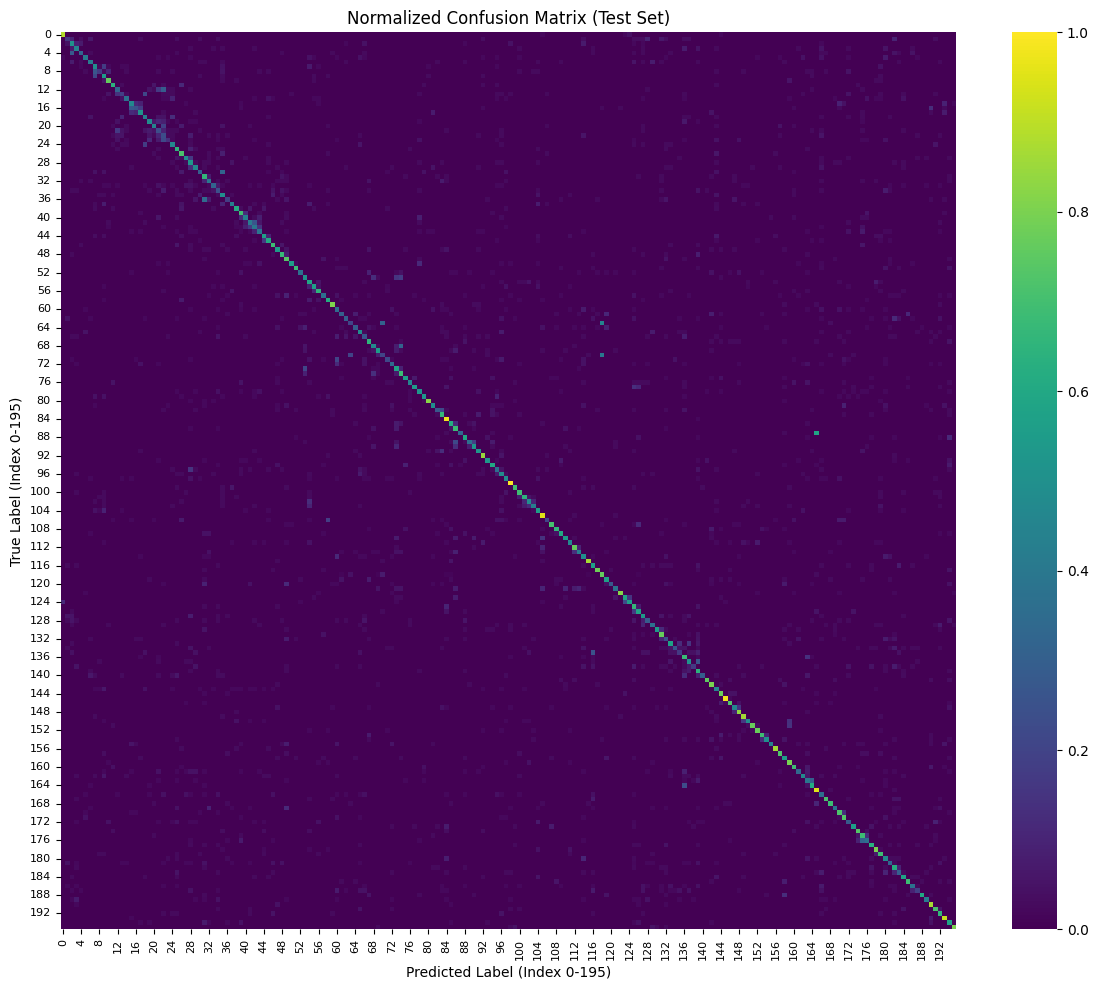


Interpretation Guide:
- The diagonal represents correct predictions (ideally bright yellow/high values).
- Off-diagonal cells represent misclassifications.
- Bright off-diagonal spots indicate common confusions between specific classes.
- Dark rows indicate classes the model struggled to recall (low true positive rate).
- Dark columns indicate classes the model frequently predicted incorrectly (low precision).
(Due to 196 classes, interpreting specific cells is difficult here; focus on overall patterns and the diagonal.)


In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

try:
    print("\n--- Generating Confusion Matrix ---")
    if 'test_predictions_indices' not in locals() or 'test_true_labels_indices' not in locals():
        raise NameError("Predictions or true labels not available.")

    # Calculate confusion matrix
    cm = confusion_matrix(test_true_labels_indices, test_predictions_indices)

    # Normalize the confusion matrix to show percentages/rates
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(12, 10)) # Adjust figure size as needed
    sns.heatmap(cm_normalized, cmap='viridis', annot=False, fmt=".2f") # Annot=False for 196 classes
    plt.title('Normalized Confusion Matrix (Test Set)')
    plt.ylabel('True Label (Index 0-195)')
    plt.xlabel('Predicted Label (Index 0-195)')
    # Adding tick labels for 196 classes will make it unreadable
    # plt.xticks(ticks=np.arange(NUM_CLASSES), labels=target_names_list, rotation=90, fontsize=4)
    # plt.yticks(ticks=np.arange(NUM_CLASSES), labels=target_names_list, rotation=0, fontsize=4)
    plt.tick_params(axis='both', which='major', labelsize=8) # Adjust tick label size if needed
    plt.tight_layout()
    plt.show()

    print("\nInterpretation Guide:")
    print("- The diagonal represents correct predictions (ideally bright yellow/high values).")
    print("- Off-diagonal cells represent misclassifications.")
    print("- Bright off-diagonal spots indicate common confusions between specific classes.")
    print("- Dark rows indicate classes the model struggled to recall (low true positive rate).")
    print("- Dark columns indicate classes the model frequently predicted incorrectly (low precision).")
    print("(Due to 196 classes, interpreting specific cells is difficult here; focus on overall patterns and the diagonal.)")


except NameError as e:
    print(f"Error: Necessary variable/data not found. {e}")
except Exception as e:
    print(f"An error occurred generating confusion matrix: {e}")

#6.8


--- Sample Test Predictions ---


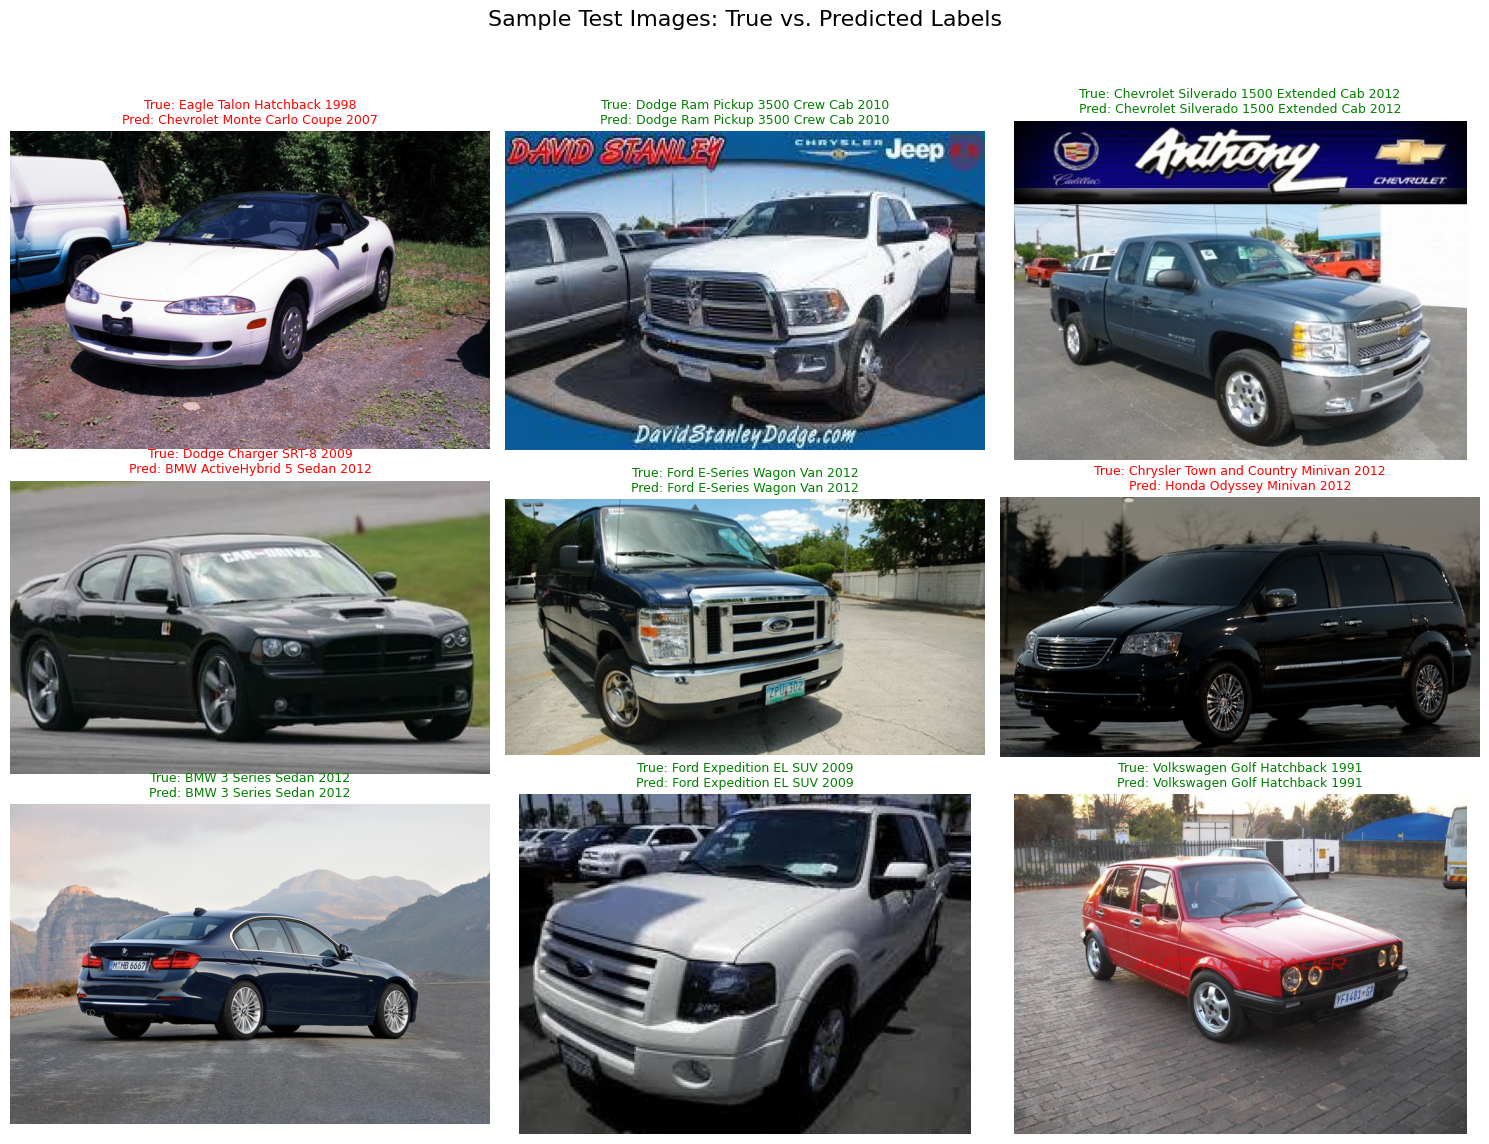

In [62]:
import random

try:
    print("\n--- Sample Test Predictions ---")
    if 'test_df' not in locals() or 'test_predictions_indices' not in locals():
         raise NameError("test_df or predictions not available.")
    if 'class_id_to_name' not in locals():
         raise NameError("class_id_to_name mapping not available.")


    num_samples_to_show = 9
    # Get random indices from the test_df
    random_indices = random.sample(range(len(test_df)), min(num_samples_to_show, len(test_df)))

    plt.figure(figsize=(15, 12)) # Adjusted size for better title spacing
    plt.suptitle("Sample Test Images: True vs. Predicted Labels", fontsize=16)

    for i, idx in enumerate(random_indices):
        # Get data for the sample at index 'idx' from the original test_df
        row = test_df.iloc[idx]
        img_path = row['filepath']
        true_label_id = row['class_id'] - 1 # Get 0-indexed true label ID
        true_label_name = row['class_name']

        # Get the predicted label index for this sample
        predicted_label_id = test_predictions_indices[idx]
        # Map predicted index back to class name
        predicted_label_name = class_id_to_name.get(predicted_label_id, "Unknown")

        plt.subplot(3, 3, i + 1)
        try:
            img = mpimg.imread(img_path) # Assumes mpimg is imported
            plt.imshow(img)
            plt.axis('off')
            title_color = 'green' if true_label_id == predicted_label_id else 'red'
            plt.title(f"True: {true_label_name}\nPred: {predicted_label_name}",
                      color=title_color, fontsize=9) # Smaller font size
        except FileNotFoundError:
             plt.title(f"Image not found\nTrue: {true_label_name}", color='grey', fontsize=9)
             plt.axis('off')
        except Exception as e:
             plt.title(f"Error loading\nTrue: {true_label_name}", color='orange', fontsize=9)
             plt.axis('off')
             print(f"Error loading sample image {img_path}: {e}")


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

except NameError as e:
    print(f"Error: Necessary variable/data not found. {e}")
except IndexError:
     print("Error: Index out of bounds. Does prediction count match test_df length?")
except Exception as e:
    print(f"An error occurred showing sample predictions: {e}")